In [17]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
import seaborn as sns
sns.set(style='whitegrid') #set seaborn plotting aesthetics
%matplotlib inline

import pydicom as dcm
from pathlib import Path
import os
from tqdm.notebook import tqdm

In [1]:
import os
import cv2
from glob import glob
import tensorflow as tf
import seaborn as sns

import math


from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model


from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input


from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [18]:
train_class = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

train_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
test_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_test_images')

train_meta = pd.concat([train_labels, 
                        train_class.drop(columns=['patientId'])], axis=1)

box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

train_ds = pd.merge(train_meta, box_df, on='patientId')

box_df = box_df.groupby('boxes').size().reset_index(name='patients')


# List of information we needs with us
vars = ['PatientAge','PatientSex','ImagePath']


def process_dicom_data(df, path):
    
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
        
    images = os.listdir(path)
    
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    
    for i, img_name in tqdm(enumerate(images)):
        
        imagePath = os.path.join(path,img_name)
        img_data = dcm.read_file(imagePath)
        
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)

process_dicom_data(train_ds,'../input/rsna-pneumonia-detection-challenge/stage_2_train_images')

0it [00:00, ?it/s]

In [19]:
train_ds.to_csv('pneumonia_ds', index=False)

### Pre Processing the image

In [21]:
import cv2

In [22]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(train_meta)
print(images.shape , labels.shape)

(30227, 128, 128, 3) (30227,)


Scikitlearn suggests using OneHotEncoder for X matrix i.e. the features you feed in a model, and to use a LabelBinarizer for the y labels.

They are quite similar, except that OneHotEncoder could return a sparse matrix that saves a lot of memory and you won't really need that in y labels.

Even if you have a multi-label multi-class problem, you can use MultiLabelBinarizer for your y labels rather than switching to OneHotEncoder for multi hot encoding.

In [23]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

## splitting into train ,test and validation data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

# CNN Model without transfer learning

In [36]:
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses,optimizers

In [42]:
## We start with 32 filters with 3,3 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [43]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)       

In [39]:
## Training for 20 epocs with batch size of 16
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16)

2022-11-25 21:04:00.861558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1039958016 exceeds 10% of free system memory.
2022-11-25 21:04:02.123058: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1039958016 exceeds 10% of free system memory.
2022-11-25 21:04:02.974914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-25 21:04:05.656697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1323/1323 [==============================] - ETA: 0s - loss: 1.8599 - accuracy: 0.3876

2022-11-25 21:04:42.167939: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 222904320 exceeds 10% of free system memory.
2022-11-25 21:04:42.869203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 222904320 exceeds 10% of free system memory.


1323/1323 [==============================] - 42s 21ms/step - loss: 1.8599 - accuracy: 0.3876 - val_loss: 1.0921 - val_accuracy: 0.4033
Epoch 2/20
1323/1323 [==============================] - 27s 21ms/step - loss: 1.0923 - accuracy: 0.3902 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 3/20
1323/1323 [==============================] - 26s 20ms/step - loss: 1.0916 - accuracy: 0.3902 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 4/20
1323/1323 [==============================] - 27s 20ms/step - loss: 1.0919 - accuracy: 0.3903 - val_loss: 1.0882 - val_accuracy: 0.4033
Epoch 5/20
1323/1323 [==============================] - 27s 20ms/step - loss: 1.0918 - accuracy: 0.3883 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 6/20
  28/1323 [..............................] - ETA: 24s - loss: 1.0855 - accuracy: 0.4062

KeyboardInterrupt: 

The Model got stuck at validation accuracy of 40%. Learning rate is too high. Let us also make use of some callbacks.

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]


In [44]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16,
                 callbacks = callbacks)

Epoch 1/20
1323/1323 [==============================] - 28s 20ms/step - loss: 1.1427 - accuracy: 0.4344 - val_loss: 0.9770 - val_accuracy: 0.4639
Epoch 2/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.9557 - accuracy: 0.5086 - val_loss: 0.9596 - val_accuracy: 0.5036
Epoch 3/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.9204 - accuracy: 0.5407 - val_loss: 0.9016 - val_accuracy: 0.5691
Epoch 4/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8885 - accuracy: 0.5605 - val_loss: 0.9008 - val_accuracy: 0.5720
Epoch 5/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8677 - accuracy: 0.5757 - val_loss: 0.8906 - val_accuracy: 0.5502
Epoch 6/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8656 - accuracy: 0.5799 - val_loss: 0.8743 - val_accuracy: 0.5755
Epoch 7/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8558 - accuracy: 0.5847 - val_loss: 0.8939 -

Training accuracy is around 60 percent whereas validation accuracy is round 58 percent. We have avoided overfitting, but it seems to be clear that a normal CNN will not help us. 

In [45]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

142/142 [==============================] - 2s 12ms/step - loss: 0.8230 - accuracy: 0.6123
Test loss: 0.8230215907096863
Test accuracy: 0.6122629046440125


Test accuracy is also 61 percent is. At least our model is consistent. Hehe. 

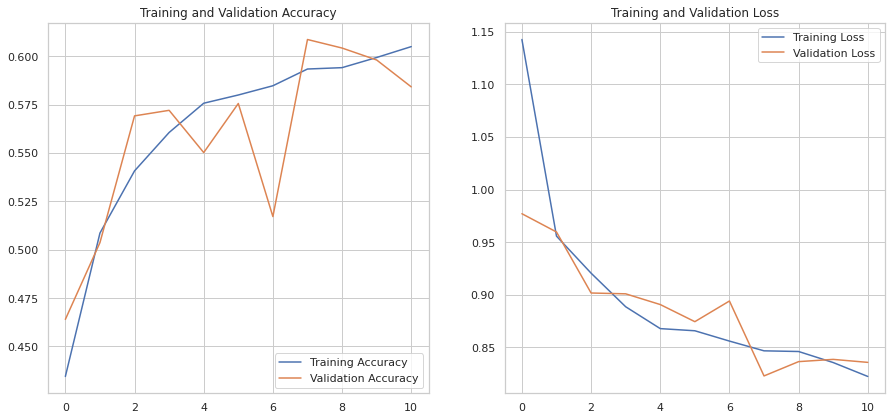

In [48]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(11)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [49]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [50]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [51]:
resultDF

,Method,accuracy,Test Score
0,CNN,0.604925,0.612263


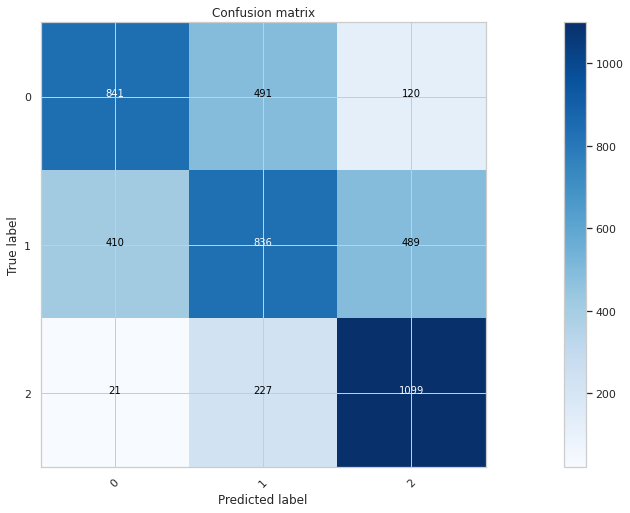

In [52]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal


In [53]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.604925,0.612263,0.537967,0.481844,0.508361,1735


In [54]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

# CNN with Tranfer learning using VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG19(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

80150528/80134624 [==============================] - 4s 0us/step


In [1]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

NameError: name 'base_model' is not defined

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/30
53/53 [==============================] - 4s 53ms/step - loss: 1.3378 - accuracy: 0.5500 - val_loss: 0.6615 - val_accuracy: 0.5667
Epoch 2/30
53/53 [==============================] - 1s 28ms/step - loss: 0.4924 - accuracy: 0.6952 - val_loss: 0.5839 - val_accuracy: 0.6806
Epoch 3/30
53/53 [==============================] - 2s 29ms/step - loss: 0.3480 - accuracy: 0.7923 - val_loss: 0.6654 - val_accuracy: 0.6333
Epoch 4/30
53/53 [==============================] - 1s 28ms/step - loss: 0.2627 - accuracy: 0.8613 - val_loss: 0.5894 - val_accuracy: 0.6583
Epoch 5/30
53/53 [==============================] - 1s 28ms/step - loss: 0.1785 - accuracy: 0.9155 - val_loss: 0.6608 - val_accuracy: 0.6583
Epoch 6/30
53/53 [==============================] - 1s 28ms/step - loss: 0.1322 - accuracy: 0.9464 - val_loss: 0.7107 - val_accuracy: 0.6333
Epoch 7/30
53/53 [==============================] - 2s 29ms/step - loss: 0.0978 - accuracy: 0.9625 - val_loss: 0.7419 - val_accuracy: 0.6139
Epoch 8/30
53

In [68]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## The Test accuracy score if 64% but the training accurayc is 100 , this model is overfit

12/12 [==============================] - 0s 23ms/step - loss: 0.5667 - accuracy: 0.6583
Test loss: 0.5667448043823242
Test accuracy: 0.6583333611488342


In [70]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",0.9571,fcl_accuracy)])


In [71]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.55119,0.516667,0.348485,0.433962,0.386555,106
0,CNN With VGG16,0.95710,0.658333,0.348485,0.433962,0.386555,106


# CNN with ResNet50

In [72]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
#model = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

94781440/94765736 [==============================] - 1s 0us/step


In [73]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 11s 109ms/step - loss: 0.6868 - accuracy: 0.5679 - val_loss: 363.5424 - val_accuracy: 0.3222
Epoch 2/30
53/53 [==============================] - 4s 81ms/step - loss: 0.5229 - accuracy: 0.6238 - val_loss: 2.0019 - val_accuracy: 0.3556
Epoch 3/30
53/53 [==============================] - 4s 81ms/step - loss: 0.4508 - accuracy: 0.6714 - val_loss: 1.3049 - val_accuracy: 0.5278
Epoch 4/30
53/53 [==============================] - 4s 83ms/step - loss: 0.4169 - accuracy: 0.6911 - val_loss: 0.4914 - val_accuracy: 0.6000
Epoch 5/30
53/53 [==============================] - 4s 83ms/step - loss: 0.4210 - accuracy: 0.7030 - val_loss: 0.7936 - val_accuracy: 0.4528
Epoch 6/30
53/53 [==============================] - 4s 81ms/step - loss: 0.3746 - accuracy: 0.7476 - val_loss: 1.4909 - val_accuracy: 0.5361
Epoch 7/30
53/53 [==============================] - 4s 81ms/step - loss: 0.3702 - accuracy: 0.7417 - val_loss: 0.4906 - val_accuracy: 0.6222
Epoch 8/3

In [74]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## Thw accuracy of test score is 58% abut training accuracy is 99% again it is an overfit model

12/12 [==============================] - 0s 27ms/step - loss: 0.9432 - accuracy: 0.6417
Test loss: 0.9432180523872375
Test accuracy: 0.6416666507720947


In [75]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])

In [76]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]



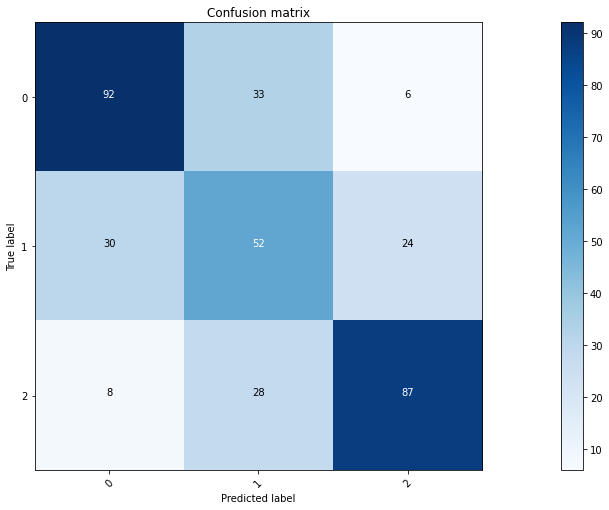

In [77]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [78]:
resultsDf2.head()
## with transfer learning we have the issue of overfitting, it does well in the training data set but not well in test
## Without TRansfer learning , the accuracy is not high but the model is general
## We will need to pre process tha image further and take more sample to conclude 

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.551190,0.516667,0.348485,0.433962,0.386555,106
0,CNN With VGG16,0.957100,0.658333,0.348485,0.433962,0.386555,106
0,CNN With ResNet50,0.981548,0.641667,0.348485,0.433962,0.386555,106


# UNet

In [79]:
labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")

In [80]:
## Getting the first 10000 data set for traingin and the next 10000 for validations
train_data = labels[0:10000]
val_data = labels[10000:20000]

train_data.fillna(0, inplace=True)
val_data.fillna(0, inplace=True)

### Creating Custom Train Generator. This will read the files in batches of 10 while training the model

In [82]:
from tensorflow.keras.applications.mobilenet import preprocess_input 

#
BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    """
    The contrast of an image is enhanced when various shades in the image becomes more distinct.
    We can do so by darkening the shades of the darker pixels and vice versa. 
    This is equivalent to widening the range of pixel intensities. To have a good contrast, 
    the following histogram characteristics are desirable:

    1) the pixel intensities are uniformly distributed across the full range of values (each intensity value is equally probable), and
    2) the cumulative histogram is increasing linearly across the full intensity range.

    Histogram equalization modifies the distribution of pixel intensities to achieve these characteristics.
    """

    def __doHistogramEqualization(self,img):
        histogram_array = np.bincount(img.flatten(), minlength=256)
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        chistogram_array = np.cumsum(histogram_array)

        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = dcm.read_file(_path)

            img = _imgData.pixel_array 
#             img = np.stack((img,)*3, axis=-1) # Expand grayscale image to contain 3 channels

            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [83]:
trainUNetDataGen = TrainGenerator( train_CombinedData)
validateUNetDataGen = TrainGenerator( validate_CombinedData)

In [87]:
LR = 1e-4

**UNET USING MobileNet**

In [89]:
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [90]:
## Build a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

In [91]:
#dice_coef 2 * the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## Loss is 1 - the coefficent of two images
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [92]:
## Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when teh validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [93]:
## Optimiser , metrics and loss for the model
opt = tf.keras.optimizers.Adam
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [94]:
## Running the model
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=16,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)


Epoch 1/16


2022-03-27 03:48:47.584791: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-27 03:48:47.584880: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-03-27 03:48:47.585325: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


50/50 [==============================] - 45s 745ms/step - loss: 0.8142 - dice_coef: 0.1858 - recall: 0.5999 - precision: 0.1267 - val_loss: 0.8582 - val_dice_coef: 0.1418 - val_recall: 0.3042 - val_precision: 0.1857
Epoch 2/16
50/50 [==============================] - 39s 743ms/step - loss: 0.7165 - dice_coef: 0.2835 - recall: 0.5134 - precision: 0.2371 - val_loss: 0.8379 - val_dice_coef: 0.1621 - val_recall: 0.5894 - val_precision: 0.1419
Epoch 3/16
50/50 [==============================] - 40s 757ms/step - loss: 0.6655 - dice_coef: 0.3345 - recall: 0.4984 - precision: 0.2909 - val_loss: 0.8138 - val_dice_coef: 0.1862 - val_recall: 0.4371 - val_precision: 0.1996
Epoch 4/16
50/50 [==============================] - 40s 746ms/step - loss: 0.6598 - dice_coef: 0.3402 - recall: 0.4770 - precision: 0.2973 - val_loss: 0.8155 - val_dice_coef: 0.1845 - val_recall: 0.4658 - val_precision: 0.1753
Epoch 5/16
50/50 [==============================] - 43s 818ms/step - loss: 0.6423 - dice_coef: 0.3577 -

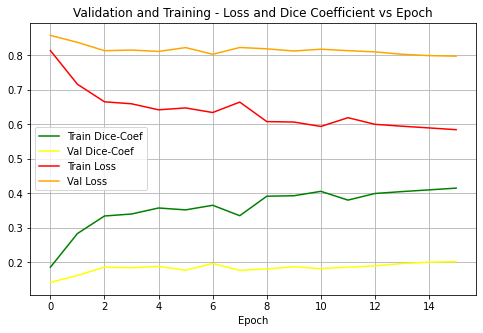

In [95]:
## PLot Matrix between training and validation data
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

val_dice-oefficient value is very low and pretty much a flat curve, indicating underfitting indicating model has not learnt sufficiently. It is steadily increasing, not sufficient training(more epochs needed).  

We have used an image size of 224x224 as against the original size of 1024x1024. Using a higher resolution, could also improve training capacity 

<li>Hyper-parameter tuning, image_augmentation, using different architectures will help in increasing model performance and generalization.


In [96]:
##Preparing test data , picked up random 20 images
test_CombinedData = labels[15000:15020]
test_CombinedData.fillna(0, inplace=True)

In [97]:
##Check target distrubution in test dataset, there are both the classes available with equal sdistrubution
test_CombinedData.Target.value_counts()

0    10
1    10
Name: Target, dtype: int64

In [99]:
## Setting the custom generator for test data
testUNetDataGen = TrainGenerator(test_CombinedData)

In [100]:
## evaluating the model
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(testUNetDataGen)

## Model evaluation , dice coef = 50% m recall is good  wiht 61% , precission is very low , of about 43.37%

2/2 [==============================] - 1s 349ms/step - loss: 0.4963 - dice_coef: 0.5037 - recall: 0.6184 - precision: 0.4316


[0.4962685704231262,
 0.5037314295768738,
 0.6183562874794006,
 0.4316089451313019]

In [101]:
## Precidt the test data that we have
pred_mask = model.predict(testUNetDataGen)


In [102]:
test_CombinedData = test_CombinedData.reset_index()


In [103]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def getPredictions(test_CombinedData):
    masks = np.zeros((int(test_CombinedData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_CombinedData.iterrows():
        patientId = row.patientId
#         print(patientId)

        classlabel = row["Target"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_CombinedData))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return
    

    


In [104]:
## Create predictions map
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_CombinedData)


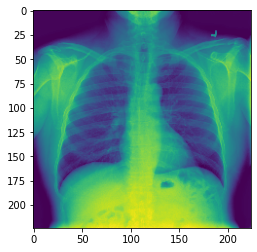

In [105]:

dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format('9358d1c5-ba61-4150-a233-41138208a3f9')
dcm_data = dcm.read_file(dcm_file)
img = dcm_data.pixel_array
plt.imshow(imagelist[12])

Text(0.5, 0, 'Pneumonia 1:')

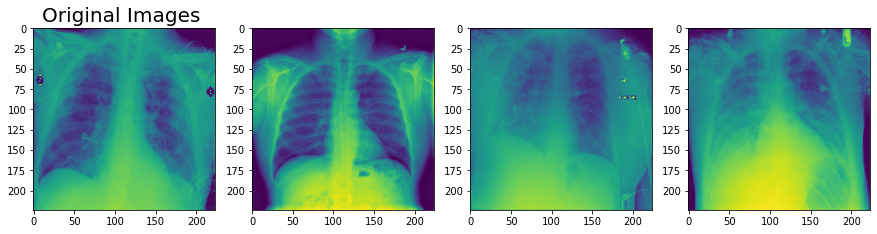

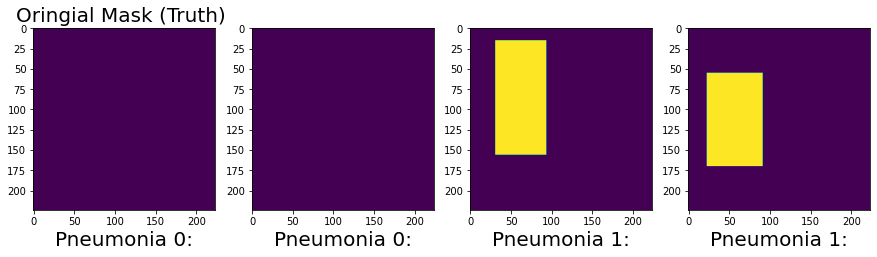

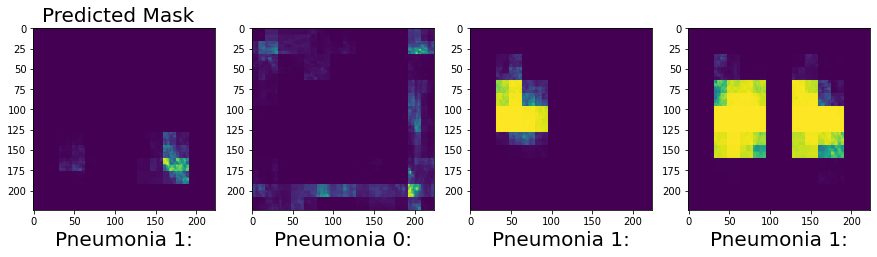

In [106]:
## Visualising the train and output data 
##
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(imagelist[1])
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)



fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)


## we could see that the first  one is mis classifed
## Second one is classified correctly , there are no masks
## Thrid is predcited correctly and the bouding box is also almost at the same position
## fourth is predicted correctly but there are two boudnign boxes, this culd be because there are duplicate patient id and we are picking only one mask to display inte Truth

Total samples =  20


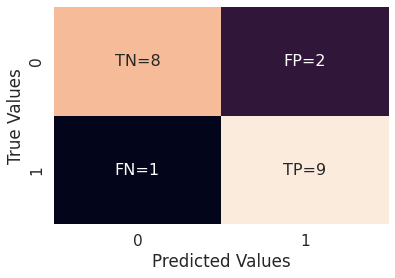

In [107]:
print_confusion_matrix(y_true,y_pred )
## There are two False Postive for Target 1

In [108]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



<font color=red> 
    <li>Recall socre is quite high for pneumonia class(target = 1), even for a very low dice-coefficient score for image mask prediction. This is a good score, because it indicates that 99% of patients who are positive are detected correctly by this model. 
    <li>Precision score is however low indicating only 83% of the predictions are correct. This is largely due to a high amount of false positives, as indicated in the confusion matrix.
    <li>The accuracy score is  0.85%, w This probably can improve as the model trains with more number of samples, that will help it to distinguish non-pneumonia images better.

1)	We have done the EDA 

2)	We have done the pre-processing of the dicom images

3)	We have built CNN model for classification without transfer learning and with Transfer learning

4)	Currently with the limited sample data set that we have taken we have found the CNN model without transfer learning was the most general model even though the accuracy was not very high

5)	We have built UNET model for regression using VGG16 Pre trained model 

6) We can improve the dice loss by image augmentation , increasing the sample size and hyper tuning
